In [1]:
import numpy as np
from scipy.sparse import dok_matrix
from math import log, sqrt
from scipy.linalg import expm
import mdptoolbox.mdp as mdp
import matplotlib.pyplot as plt
import numpy.ma as ma
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Polygon

Parameter

In [2]:
# Wright-Fisher parameters
N_pop = 5000          # Total population size
mutation_rate = 0.001 # Mutation rate
tau = 1000            # Total generations
dt = 1                # Time step

# Drug fitness profiles
actions = [0, 1, 2, 3]  # Possible drug actions
drug_lists = {
    0: [0.994, 0.997, 1.009],  # Drug A
    1: [1.000, 0.991, 1.008],  # Drug B
    2: [0.999, 1.003, 0.994],  # Drug C 
    3: [0.993, 1.005, 1.002]   # Drug D 
}

# State Grid
L = 100               # Grid resolution
a = 1 / L             
N_states = L * L      # Total number of states

states = [(a * (0.5 + i), a * (0.5 + j)) for j in range(L) for i in range(L)]

Helper Function

In [3]:
def get_f(action):
    return drug_lists[action]

def get_s(action):
    f = get_f(action)
    s1 = f[1] / f[0] - 1
    s2 = f[2] / f[0] - 1
    return s1, s2

def unpack(u):
    x1 = u[0]
    x2 = u[1] * (1 - x1)
    x0 = 1 - x1 - x2
    return x0, x1, x2

def get_f_u_mean(u, action):
    return np.dot(unpack(u[0], u[1]), np.array(get_f(action)))

def normalize_eigenvector(eigenvector):
    """Normalize eigenvector to sum to 1 with positive values."""
    if np.all(eigenvector < 0):
        eigenvector = -eigenvector
    total_sum = np.sum(eigenvector)
    return eigenvector.real / total_sum

In [ ]:
# Fokker-Planck
def A1(u, action):
    s1, s2 = get_s(action)
    return mutation_rate - 3*mutation_rate*u[0] + u[0]*(1-u[0])*(s1 - u[1]*s2)

def A2(u, action):
    s1, s2 = get_s(action)
    return (mutation_rate - 2*mutation_rate*u[1])/(1-u[0]) + u[1]*(1-u[1])*s2

def D1(u):
    return u[0] * (1 - u[0]) / (2 * N_pop)

def D2(u):
    return u[1] * (1 - u[1]) / (2 * N_pop * (1 - u[0]))

def energy(u, action):
    s1, s2 = get_s(action)
    E = 2 * N_pop * (1 - u[0]) * (s1 - s2 * u[1]) - log(4 * (u[0] * (1 - u[0]) * u[1]*(1-u[1]))**(2*mutation_rate*N_pop - 1) * (1 - u[0])**(2*mutation_rate*N_pop))
    return E

In [ ]:
# Discrete Markov Model
def build_transition_rate_matrix(action,states):
    
    Omega = dok_matrix((L*L, L*L), dtype=np.float64)

    # Loop over all states to define the off-diagonal rates.
    for n in range(N_states):
        u = states[n]  # current state (u1, u2)
        
        # RIGHT neighbor: m = n+1 if not on the right boundary.
        # In a 0-indexed array, if n % L != L - 1 then we can move right.
        if (n % L) != (L - 1):
            m = n + 1
            rate = D1(u)/a**2 + A1(u, action)/(2*a)
            Omega[n, m] = rate
            
        # LEFT neighbor: m = n-1 if not on the left boundary.
        if (n % L) != 0:
            m = n - 1
            rate = D1(u)/a**2 - A1(u, action)/(2*a)
            Omega[n, m] = rate
            
        # UP neighbor: m = n+L if not on the top boundary.
        if n < L * (L - 1):
            m = n + L
            rate = D2(u)/a**2 + A2(u, action)/(2*a)
            Omega[n, m] = rate
            
        # DOWN neighbor: m = n-L if not on the bottom boundary.
        if n >= L:
            m = n - L
            rate = D2(u)/a**2 - A2(u, action)/(2*a)
            Omega[n, m] = rate

    # Set diagonal elements such that row sums are zero.
    for n in range(N_states):
        row_sum = Omega[n, :].sum()
        Omega[n, n] = -row_sum

    return Omega.tocsr()

def build_transition_matrix(transition_rate_matrix, dt):
    W = expm(transition_rate_matrix.toarray()*dt)
    W[W < 0] = 0.0                         # clip tiny negatives
    row_sums = W.sum(axis=1, keepdims=True)
    W = W / row_sums                       # renormalize rows
    return W

In [ ]:
# MDP
def compute_reward(state, action):
    x0, x1, x2 = unpack(state)
    f0, f1, f2 = get_f(action)  
    fitness = x0*f0 + x1*f1 + x2*f2  
    return -fitness  # Negative reward to minimize fitness

def build_W_and_R(actions, states, dt):
    """Return P-list and R-matrix for all actions."""
    N_states = len(states)
    P = []
    R = np.zeros((N_states, len(actions)), dtype=np.float64)

    for a in actions:
        Omega   = build_transition_rate_matrix(a, states)
        W  = build_transition_matrix(Omega, dt)
        P.append(W)
        for i, s in enumerate(states):
            R[i, a] = compute_reward(s, a)
    return P, R

MDP solution

In [4]:
W, R = build_W_and_R(actions, states, dt)
vi = mdp.ValueIteration(transitions=W, reward=R, discount=0.99, epsilon=1e-4, max_iter=1000)
vi.run()

policy_grid = np.array(vi.policy).reshape((L, L))
used_drugs = np.unique(np.array(vi.policy))

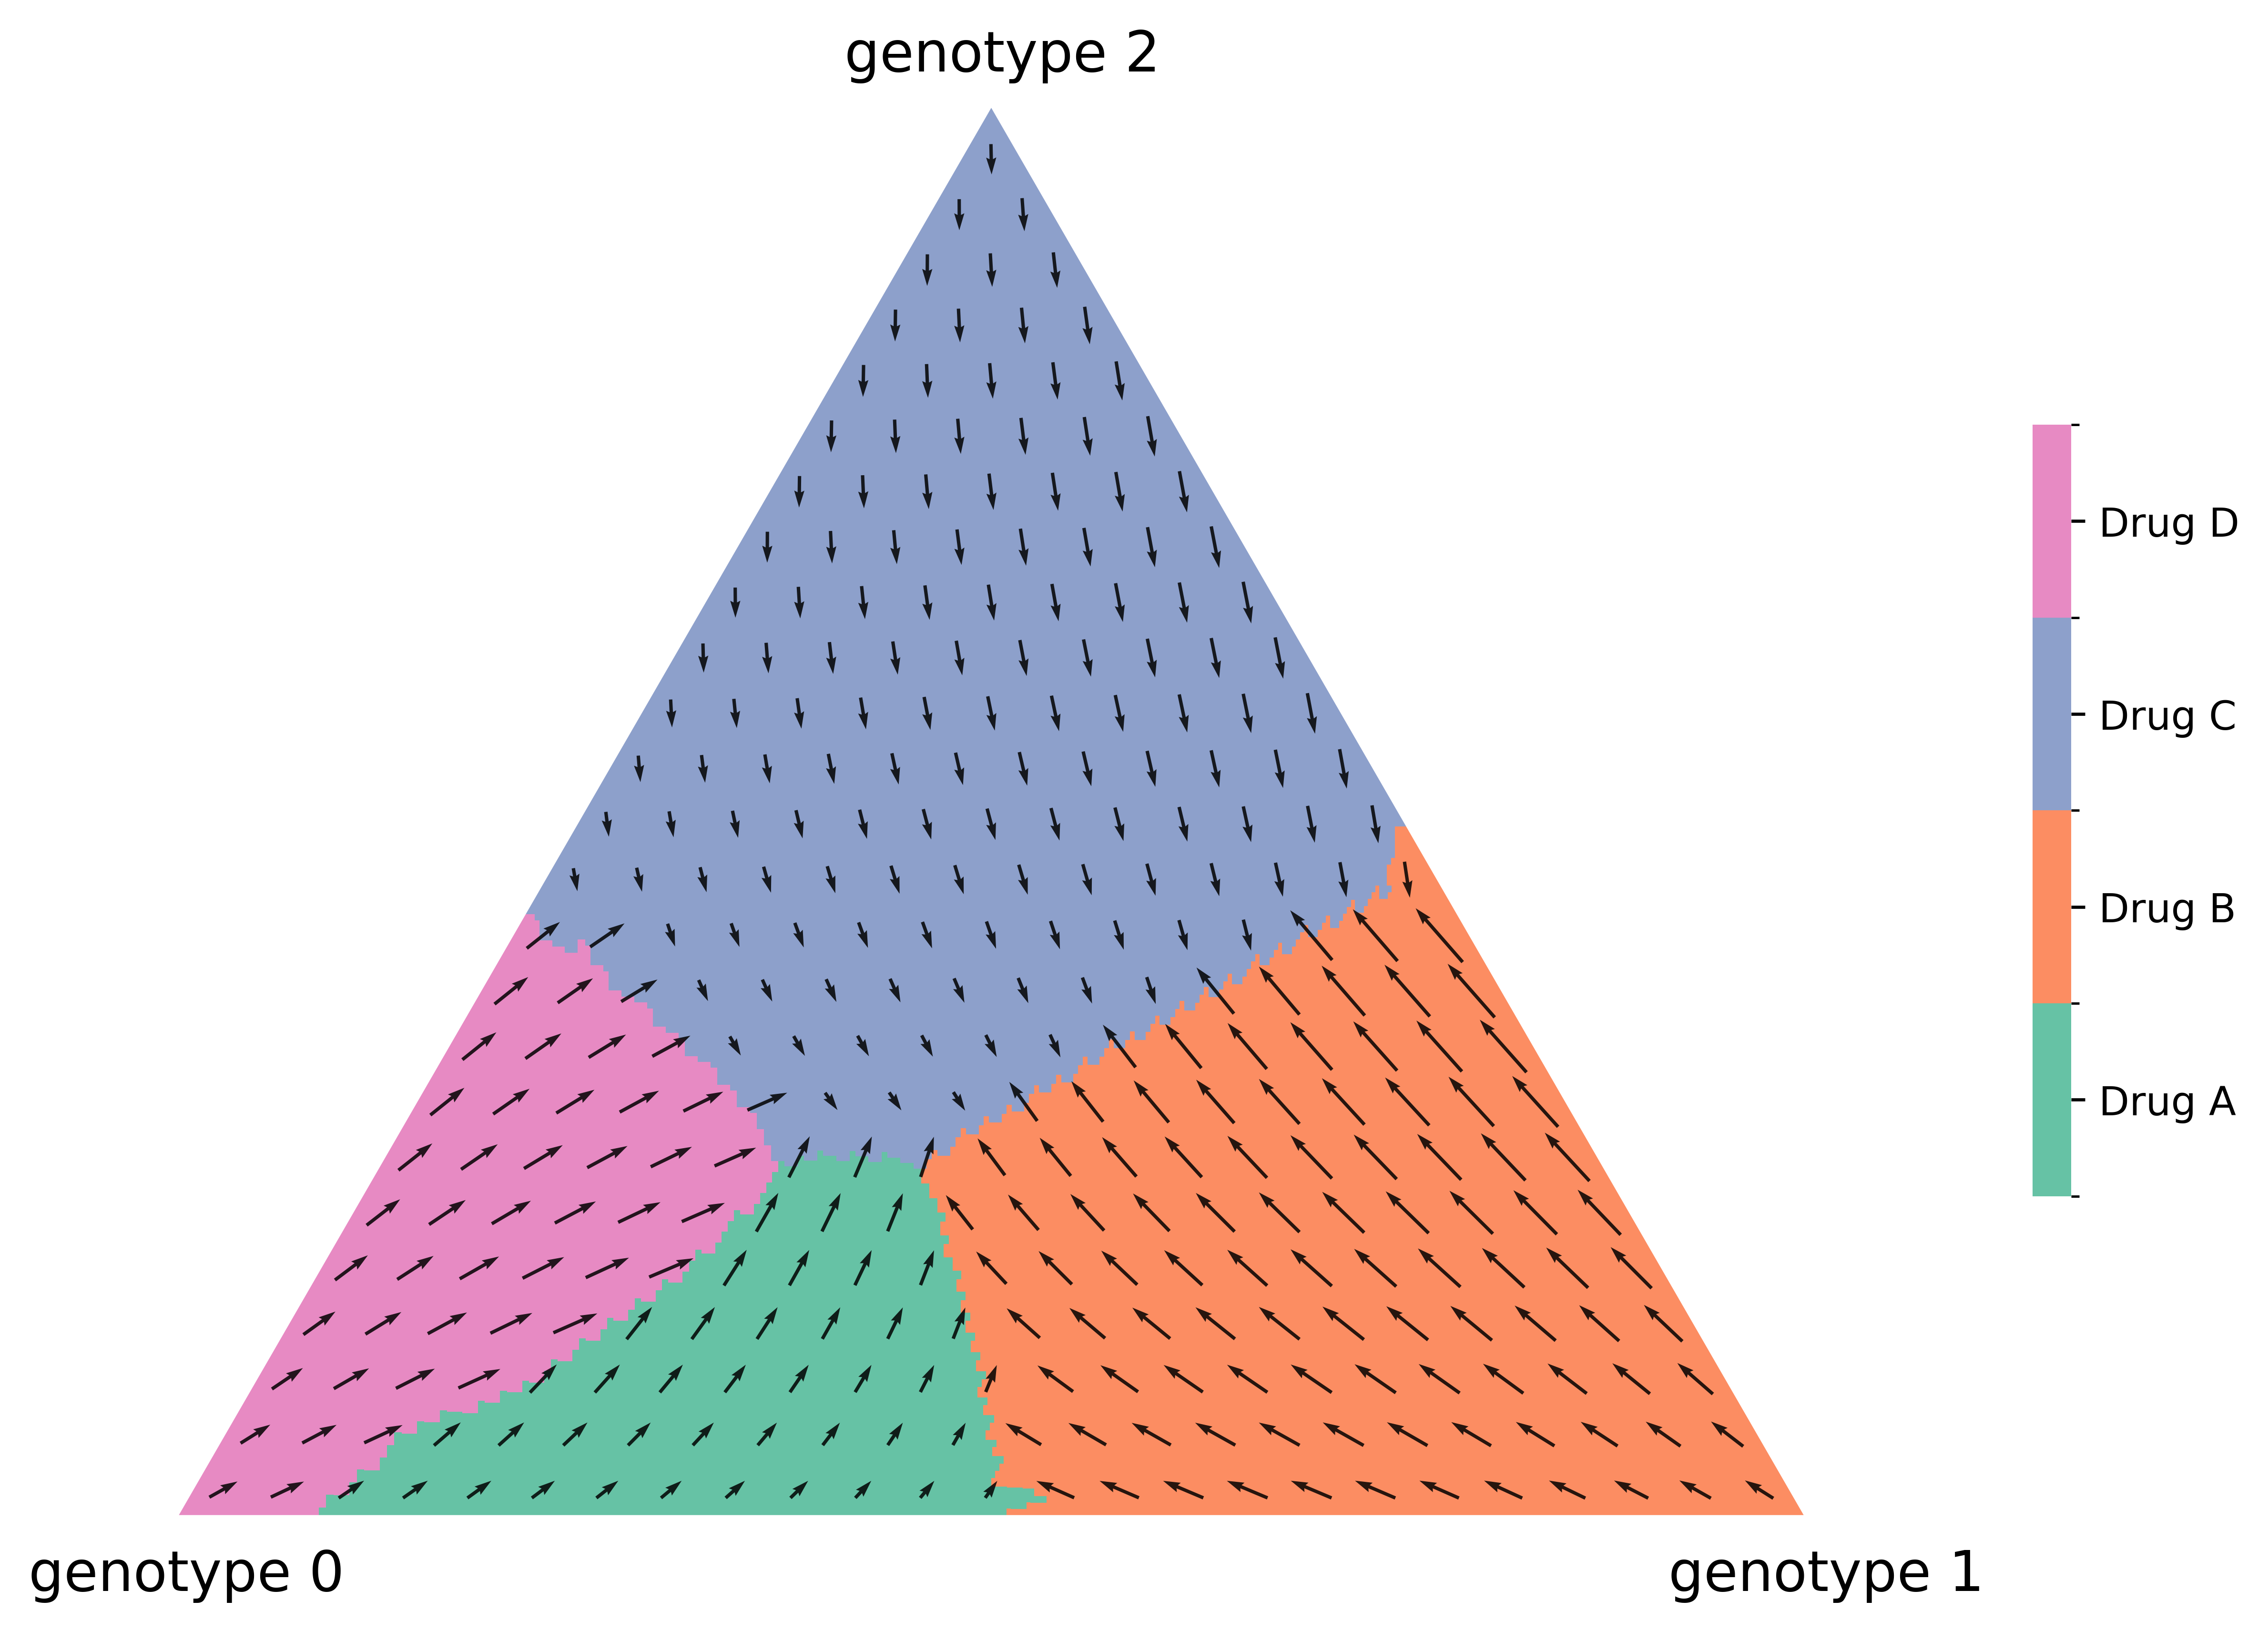

In [32]:
# -----------------------------
# Build u-grid arrays and drifts V1,V2 under optimal policy
# -----------------------------
u_vals = np.linspace(a/2, 1 - a/2, L)
U1, U2 = np.meshgrid(u_vals, u_vals)  # shape [L,L]
V1 = np.zeros_like(U1)
V2 = np.zeros_like(U2)
for j in range(L):
    for i in range(L):
        act = int(policy_grid[j, i])
        V1[j, i] = A1((U1[j, i], U2[j, i]), act)
        V2[j, i] = A2((U1[j, i], U2[j, i]), act)

# -----------------------------
# Map the u-grid to simplex for the policy background
# -----------------------------
# x1 = u1; x2 = (1 - u1) * u2; (X,Y) = (x1 + 0.5 x2, sqrt(3)/2 x2)
X_cart = U1 + 0.5 * (1 - U1) * U2
Y_cart = (np.sqrt(3)/2) * (1 - U1) * U2
Xf, Yf = X_cart.ravel(), Y_cart.ravel()

# colors for policy background
drug_names = ['A','B','C','D']
cmap = ListedColormap(['#66c2a5','#fc8d62','#8da0cb','#e78ac3'])  # A,B,C,D
norm = BoundaryNorm(boundaries=np.arange(-0.5, 4.5, 1), ncolors=4)

# -----------------------------
# Push-forward of drift (for grid; used only if you also want grid quiver)
# dx2 = -u2*V1 + (1-u1)*V2 ; dX = V1 + 0.5*dx2 ; dY = sqrt(3)/2 * dx2
# -----------------------------
dx2_grid = -U2 * V1 + (1 - U1) * V2
dX_grid  = V1 + 0.5 * dx2_grid
dY_grid  = (np.sqrt(3)/2) * dx2_grid

M = 24                 # controls density (larger => more arrows)
den = M + 1.5          # keeps all points slightly inside edges

X_list, Y_list = [], []
u1_list, u2_list, act_list = [], [], []

for i in range(M + 1):
    for j in range(M + 1 - i):
        k = M - i - j

        # barycentric (x0,x1,x2), uniformly spread over triangle
        x0 = (i + 0.5) / den
        x1 = (j + 0.5) / den
        x2 = (k + 0.5) / den
        # (x0+x1+x2)=1 by construction

        # map to 2D Cartesian
        X = x1 + 0.5 * x2
        Y = (np.sqrt(3)/2) * x2

        # map to u-space for drift/policy lookup
        u1 = x1
        u2 = x2 / (1 - x1)

        # nearest u-grid cell to choose action (policy is piecewise-constant)
        ui = int(np.clip(np.round((u1 - a/2)/a), 0, L-1))
        uj = int(np.clip(np.round((u2 - a/2)/a), 0, L-1))
        act = int(policy_grid[uj, ui])

        X_list.append(X); Y_list.append(Y)
        u1_list.append(u1); u2_list.append(u2)
        act_list.append(act)

Xs  = np.array(X_list)
Ys  = np.array(Y_list)
u1s = np.array(u1_list)
u2s = np.array(u2_list)
acts= np.array(act_list)

# drift at the lattice points (in u), then push forward to simplex
V1_s = np.array([A1((u1, u2), a_) for u1, u2, a_ in zip(u1s, u2s, acts)])
V2_s = np.array([A2((u1, u2), a_) for u1, u2, a_ in zip(u1s, u2s, acts)])

dx2_s = -u2s * V1_s + (1 - u1s) * V2_s
dX_s  = V1_s + 0.5 * dx2_s
dY_s  = (np.sqrt(3)/2) * dx2_s

# -----------------------------
# Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(8,7), dpi=600)

# policy background (square markers clipped to triangle)
pix_to_pt = 72/300
fig_w_px  = fig.get_figwidth() * fig.dpi
cell_px   = fig_w_px / L
cell_pt   = cell_px * pix_to_pt
s_val     = cell_pt**2

sc = ax.scatter(
    Xf, Yf,
    c=policy_grid.ravel(),
    cmap=cmap, norm=norm,
    marker='s', s=s_val,
    linewidths=0, edgecolors='none'
)

# clip to simplex triangle
triangle_coords = np.array([[0,0],[1,0],[0.5,np.sqrt(3)/2]])
clip_path = Polygon(triangle_coords, closed=True, transform=ax.transData)
sc.set_clip_path(clip_path)

# quiver arrows at uniformly sampled simplex points
ax.quiver(
    Xs, Ys,
    dX_s, dY_s,
    angles='xy', scale_units='xy', scale=0.1,
    pivot='mid', width=0.002, color='k', alpha=0.85
)

# simplex boundary & labels
triangle = np.array([[0,0],[1,0],[0.5,np.sqrt(3)/2],[0,0]])
ax.plot(triangle[:,0], triangle[:,1], '-', lw=1, color='white')
ax.set_aspect('equal')
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, np.sqrt(3)/2 + 0.02)
ax.set_xticks([]); ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.text(-0.09, -0.045, 'genotype 0', fontsize=14)
ax.text(0.915, -0.045, 'genotype 1', fontsize=14)
ax.text(0.41,  np.sqrt(3)/2 + 0.02, 'genotype 2', fontsize=14)

# colorbar
cbar = plt.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax, ticks=[0,1,2,3], fraction=0.02, pad=0.1
)
cbar.ax.set_yticklabels([f'Drug {n}' for n in ['A','B','C','D']])
cbar.outline.set_visible(False)

plt.tight_layout()
plt.show()

In [6]:
# time vector
t_step = int(tau / dt)
t = np.linspace(0, tau, t_step + 1)

num_genotypes = 3

# map continuous freq→discrete index
def freq_to_state_idx(freq, L):
    x1, x2 = freq[1], freq[2]
    x1 = np.clip(np.nan_to_num(x1, 0, 1, 0), 0, 1)
    x2 = np.clip(np.nan_to_num(x2, 0, 1, 0), 0, 1)
    u1 = x1
    den = 1 - u1
    u2 = 0 if den<=0 else np.clip(x2/den, 0, 1)
    i = min(max(int(np.floor(u1*L)), 0), L-1)
    j = min(max(int(np.floor(u2*L)), 0), L-1)
    return j*L + i

# single WF run given a drug‐picker
def mdp_picker(freq):
    idx = freq_to_state_idx(freq, L)
    return vi.policy[idx]

def run_wf(picker):
    # build symmetric mutation matrix Q (j→i)
    Q = np.full((num_genotypes, num_genotypes), mutation_rate)
    np.fill_diagonal(Q, 1 - mutation_rate*(num_genotypes - 1))

    counts = np.array([N_pop] + [0]*(num_genotypes-1), int)
    freq   = counts / N_pop
    fit_traj    = np.zeros(t_step+1)
    freq_traj   = np.zeros((t_step+1, num_genotypes))
    action_traj = np.zeros(t_step+1, int)

    # gen 0
    a0           = picker(freq)
    fit_traj[0]  = freq.dot(get_f(a0))
    freq_traj[0] = freq
    action_traj[0] = a0

    # gens 1…τ
    for gen in range(1, t_step+1):
        a      = picker(freq)
        f_vec  = np.array(get_f(a), float)
        # selection
        w_bar    = freq.dot(f_vec)
        freq_sel = (freq * f_vec) / w_bar
        # mutation (symmetric)
        freq_mut = Q.T @ freq_sel
        # drift
        counts = np.random.multinomial(N_pop, freq_mut)
        freq   = counts / N_pop

        fit_traj[gen]    = freq.dot(f_vec)
        freq_traj[gen]   = freq
        action_traj[gen] = a

    return fit_traj, freq_traj, action_traj

In [7]:
# 1000 replicates
n_reps = 10000
all_fit = np.zeros((len(actions)+1, n_reps, t_step+1))

gens_of_interest = [200, 600, 1000]
samples_mdp = {g: [] for g in gens_of_interest}

# single‐drug
for d in actions:
    picker = lambda freq, drug=d: drug
    for r in range(n_reps):
        all_fit[d, r], _, _ = run_wf(picker)

# MDP
for r in range(n_reps):
    all_fit[-1, r], freq_traj, _ = run_wf(mdp_picker)
    # collect genotype frequencies at specified generations
    for g in gens_of_interest:
        samples_mdp[g].append(freq_traj[g])  # shape (3,) per replicate

# compute stats
mean_fit = all_fit.mean(axis=1)
std_fit  = all_fit.std( axis=1)

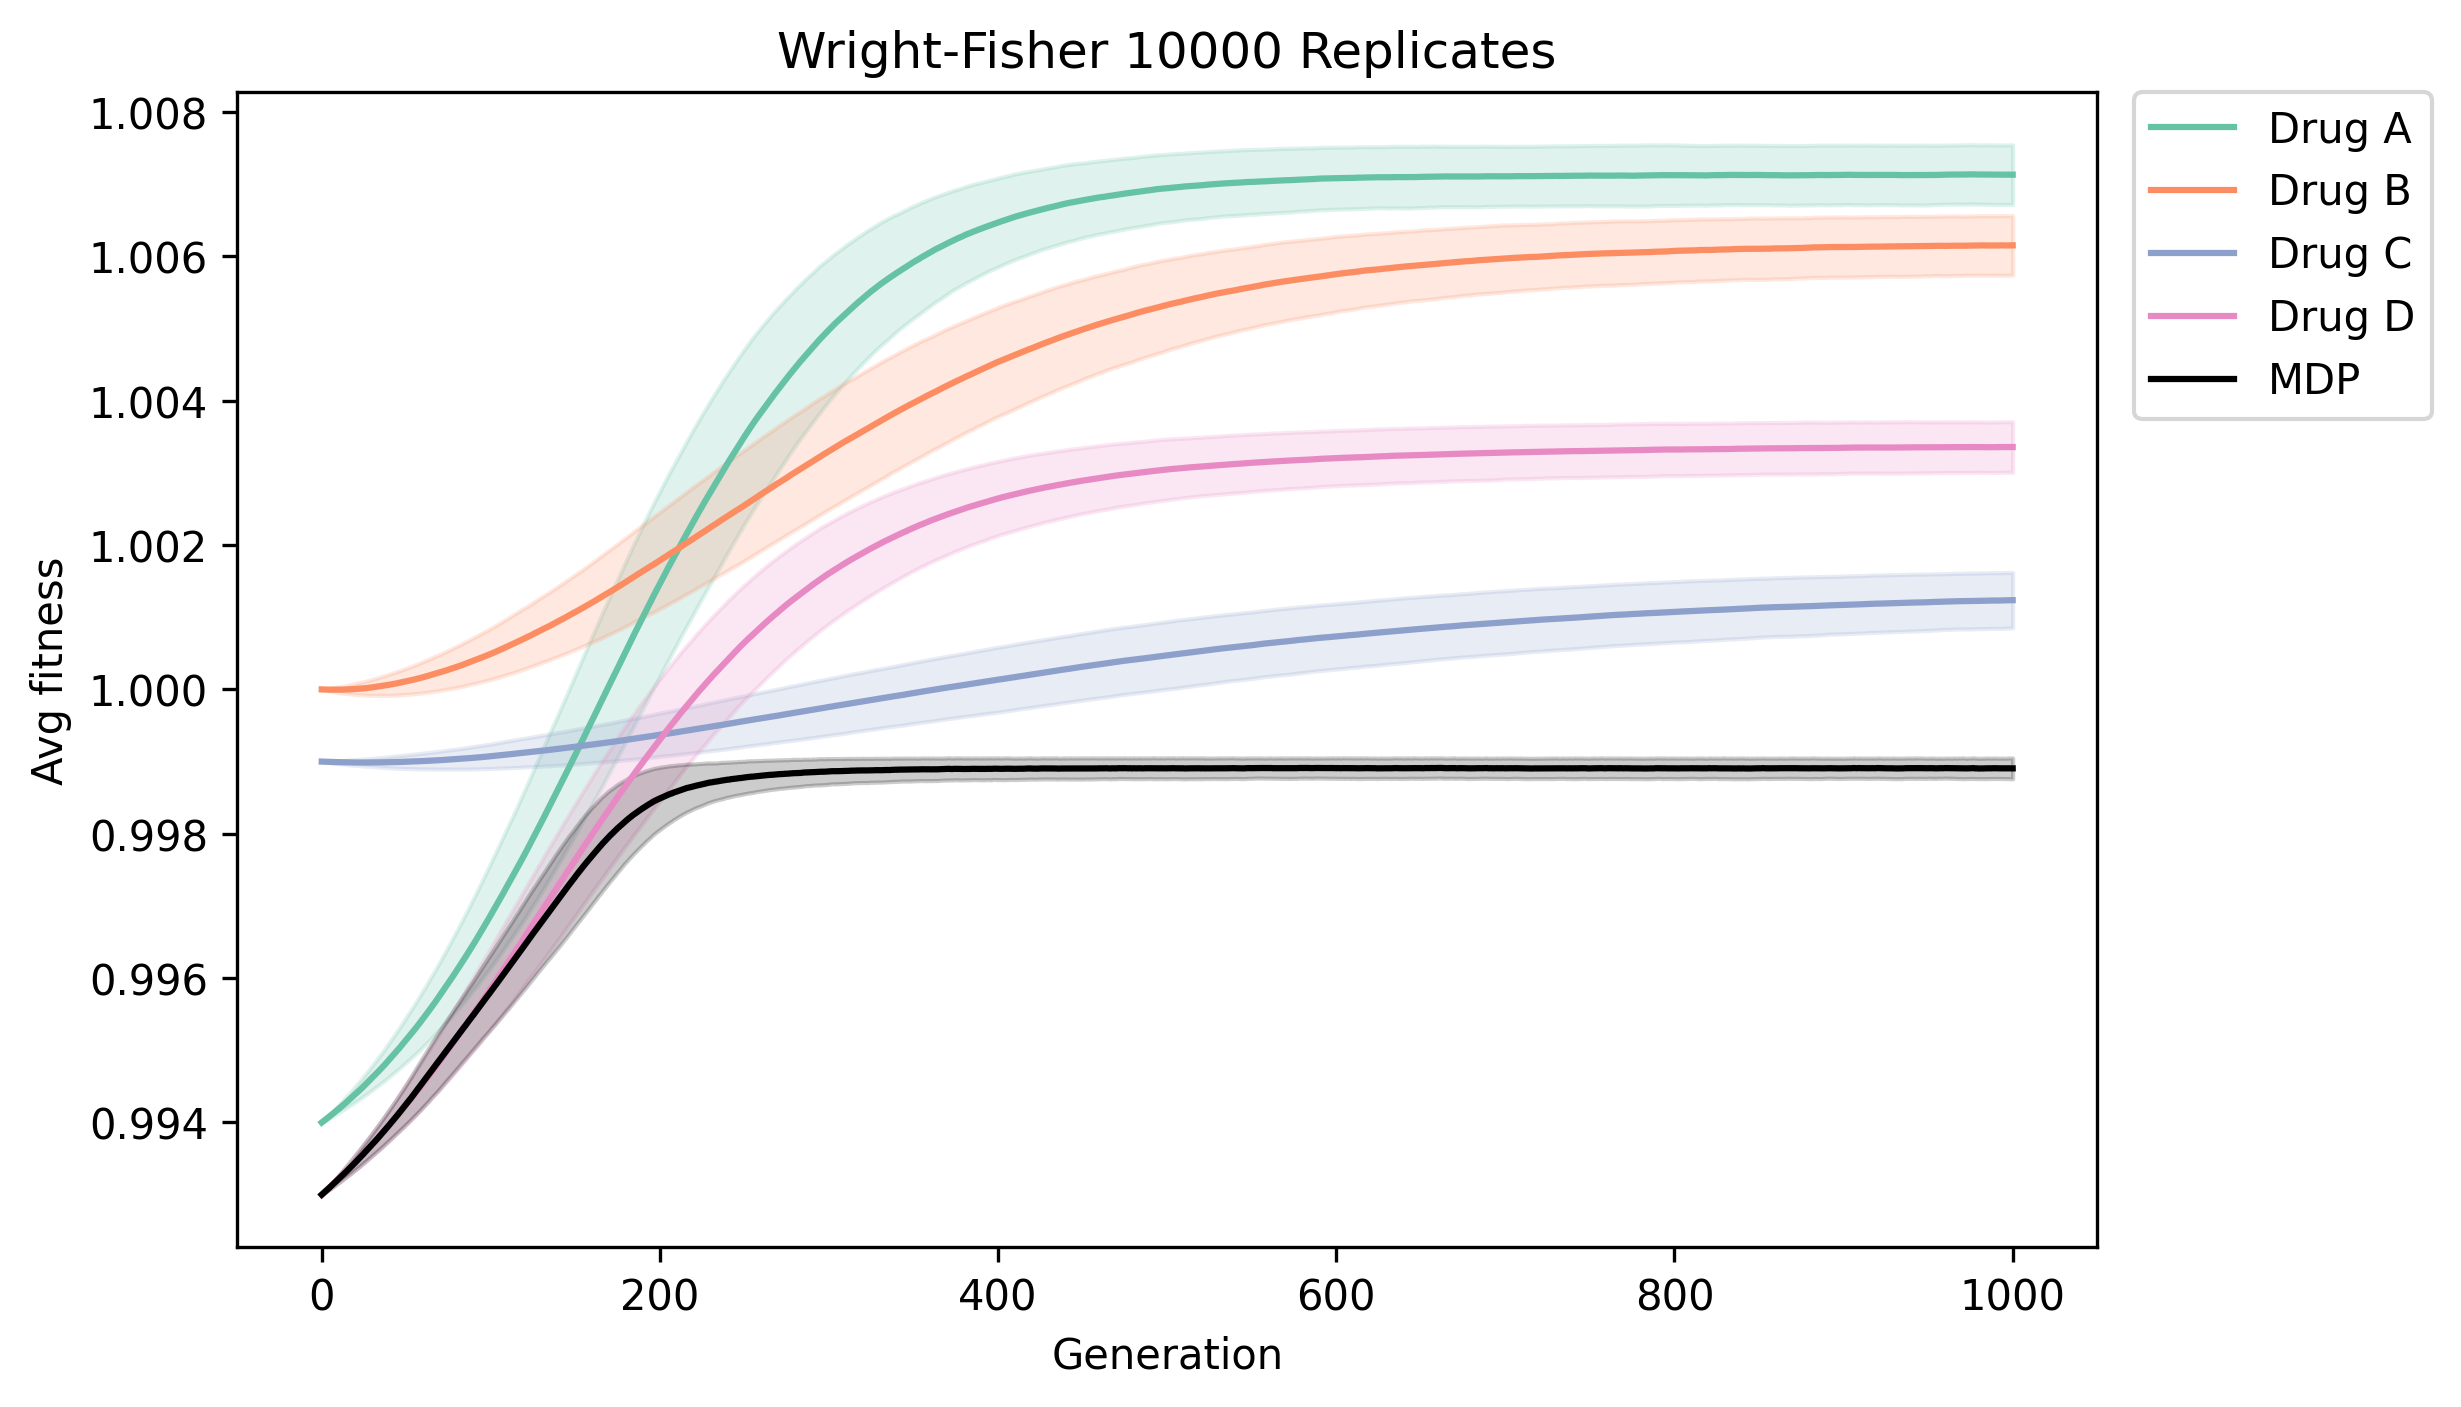

In [8]:
# plot
plt.figure(figsize=(8,5), dpi=300)
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', 'black']
labels = [f"Drug {n}" for n in drug_names] + ["MDP"]

for i in range(len(actions)+1):
    plt.plot(t, mean_fit[i], color=colors[i], label=labels[i])
    plt.fill_between(t,
                     mean_fit[i]-std_fit[i],
                     mean_fit[i]+std_fit[i],
                     color=colors[i], alpha=0.2)

plt.xlabel("Generation")
plt.ylabel("Avg fitness")
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.title(f"Wright-Fisher {n_reps} Replicates")
plt.show()

Global min: 0.991 Global max: 1.009


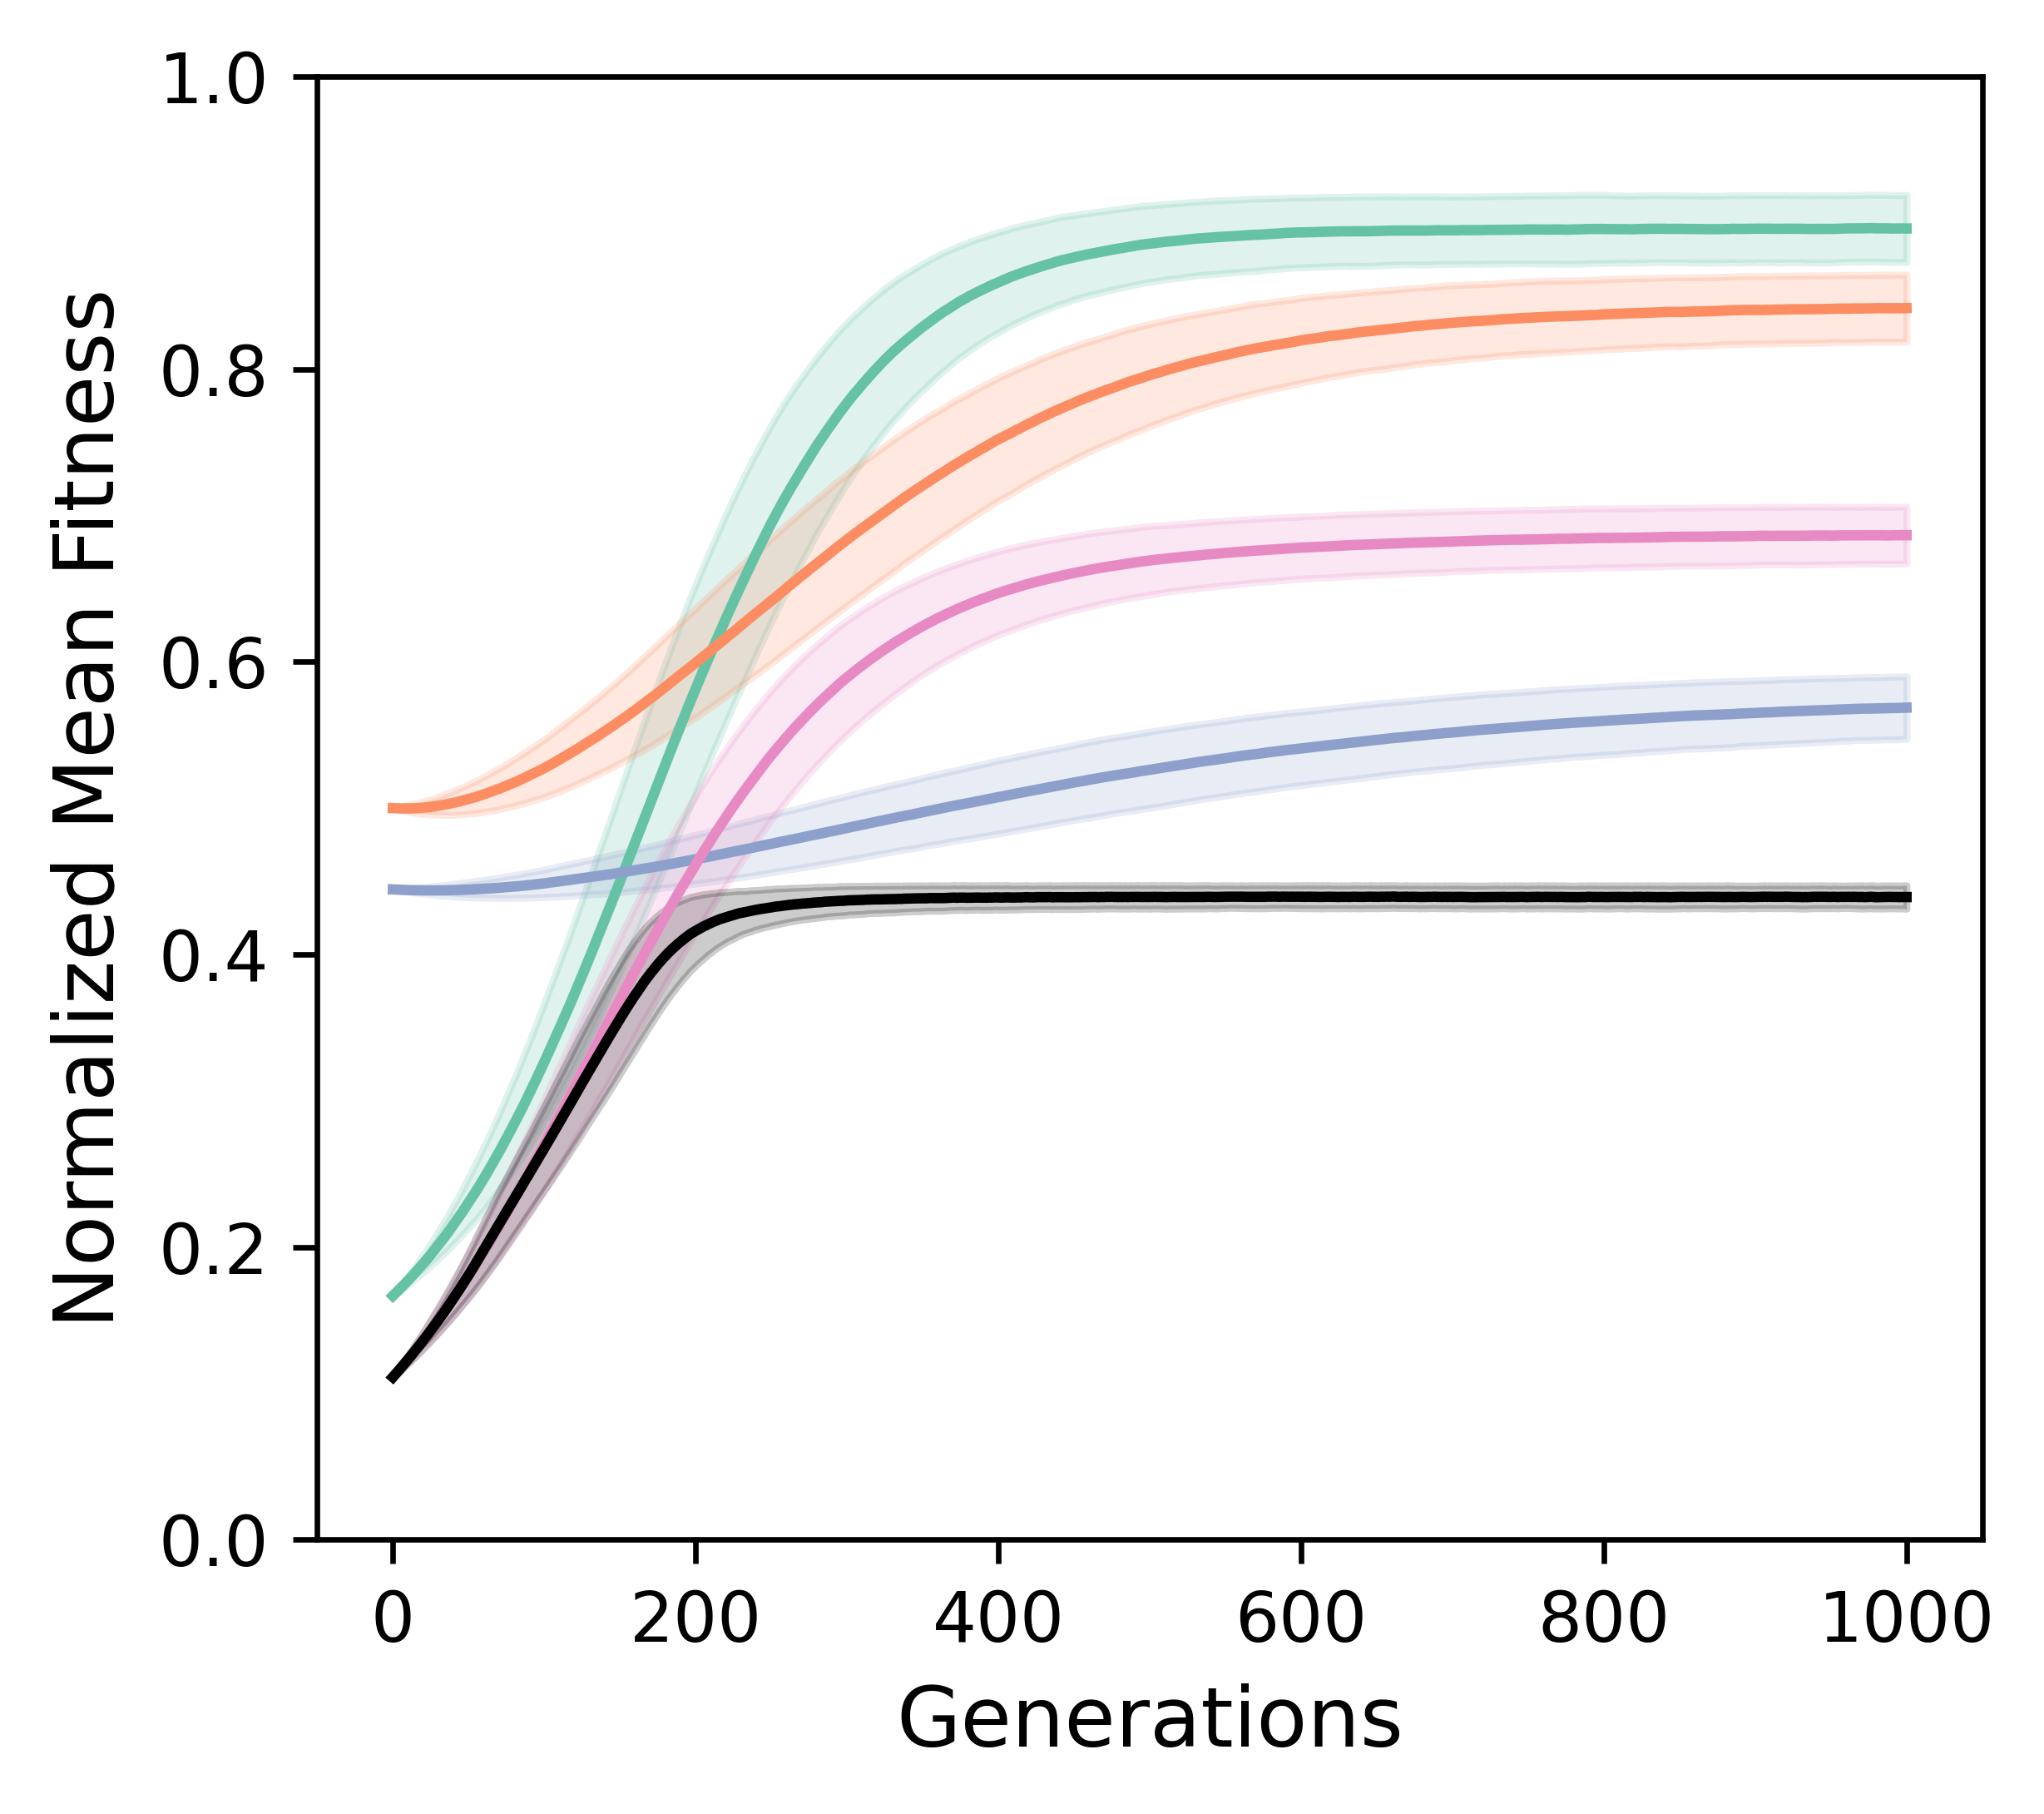

In [121]:
# collect all fitness values
all_fits = np.concatenate(list(map(np.array, drug_lists.values())))
global_min = all_fits.min()
global_max = all_fits.max()
print("Global min:", global_min, "Global max:", global_max)

# normalize mean_fit and std_fit by min-max scaling
mean_fit_norm = (mean_fit - global_min) / (global_max - global_min)
std_fit_norm  = std_fit / (global_max - global_min)   # scale std by same denominator

# --- plot ---
plt.figure(figsize=(4.2, 4/4.5*4.2), dpi=600)
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', 'black']
labels = [f"Drug {n}" for n in drug_names] + ["MDP"]

for i in range(len(actions)+1):
    m = mean_fit_norm[i]
    s = std_fit_norm[i]
    plt.plot(t, m, color=colors[i], label=labels[i])
    plt.ylim(0,1)
    plt.fill_between(t, m - s, m + s, color=colors[i], alpha=0.2)

plt.xlabel("Generations", fontsize=12)
plt.ylabel("Normalized Mean Fitness", fontsize=12)
#plt.title(f"Wright–Fisher {n_reps} Replicates (min–max normalized)")
#plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0, frameon=False)
plt.tight_layout()
plt.show()


2 drug switching

In [102]:
import itertools

# ---------- ordered pairs (A→B and B→A are distinct) ----------
pairs = list(itertools.combinations(actions, 2))   # len = 6 for 4 drugs
pair_labels = [f"Drug {drug_names[a]}↔{drug_names[b]}" for a, b in pairs]

# ---------- alternating picker (no change to run_wf) ----------
def make_alt_picker_first(a, b, block_len=1):
    """Return picker(freq) that yields A→B→A→B… in blocks of length `block_len`."""
    counter = {'i': 0}
    def picker(_freq, a=a, b=b, block_len=block_len):
        blk = counter['i'] // block_len
        counter['i'] += 1
        return a if (blk % 2 == 0) else b
    return picker

# ---------- run the 6 A↔B policies ----------
n_pairs = len(pairs)
all_fit_two = np.zeros((n_pairs + 1, n_reps, t_step + 1))  # extra row for MDP

for p_idx, (a, b) in enumerate(pairs):
    for r in range(n_reps):
        # fresh picker per replicate to avoid counter leakage
        alt_picker = make_alt_picker_first(a, b, block_len=1)  # set block_len>1 for A…A B…B
        all_fit_two[p_idx, r], _, _ = run_wf(alt_picker)

In [114]:
from matplotlib.colors import to_rgb, to_hex

# --- helpers for pair colors (gamma-corrected blend) ---
single_color = {'A':'#66c2a5','B':'#fc8d62','C':'#8da0cb','D':'#e78ac3'}

def blend_hex(c1, c2, w=0.5, gamma=2.2):
    r1,g1,b1 = to_rgb(c1); r2,g2,b2 = to_rgb(c2)
    r1,g1,b1 = r1**gamma, g1**gamma, b1**gamma
    r2,g2,b2 = r2**gamma, g2**gamma, b2**gamma
    rl = (1-w)*r1 + w*r2; gl = (1-w)*g1 + w*g2; bl = (1-w)*b1 + w*b2
    return to_hex((rl**(1/gamma), gl**(1/gamma), bl**(1/gamma)))

def color_for_pair(a_idx, b_idx, w=0.5):
    na, nb = drug_names[a_idx], drug_names[b_idx]  # e.g., 'A','B'
    return blend_hex(single_color[na], single_color[nb], w=w)

# Build colors to match your `pairs` and `pair_labels`
pair_colors = [color_for_pair(a, b, w=0.5) for (a, b) in pairs]   # 6 colors


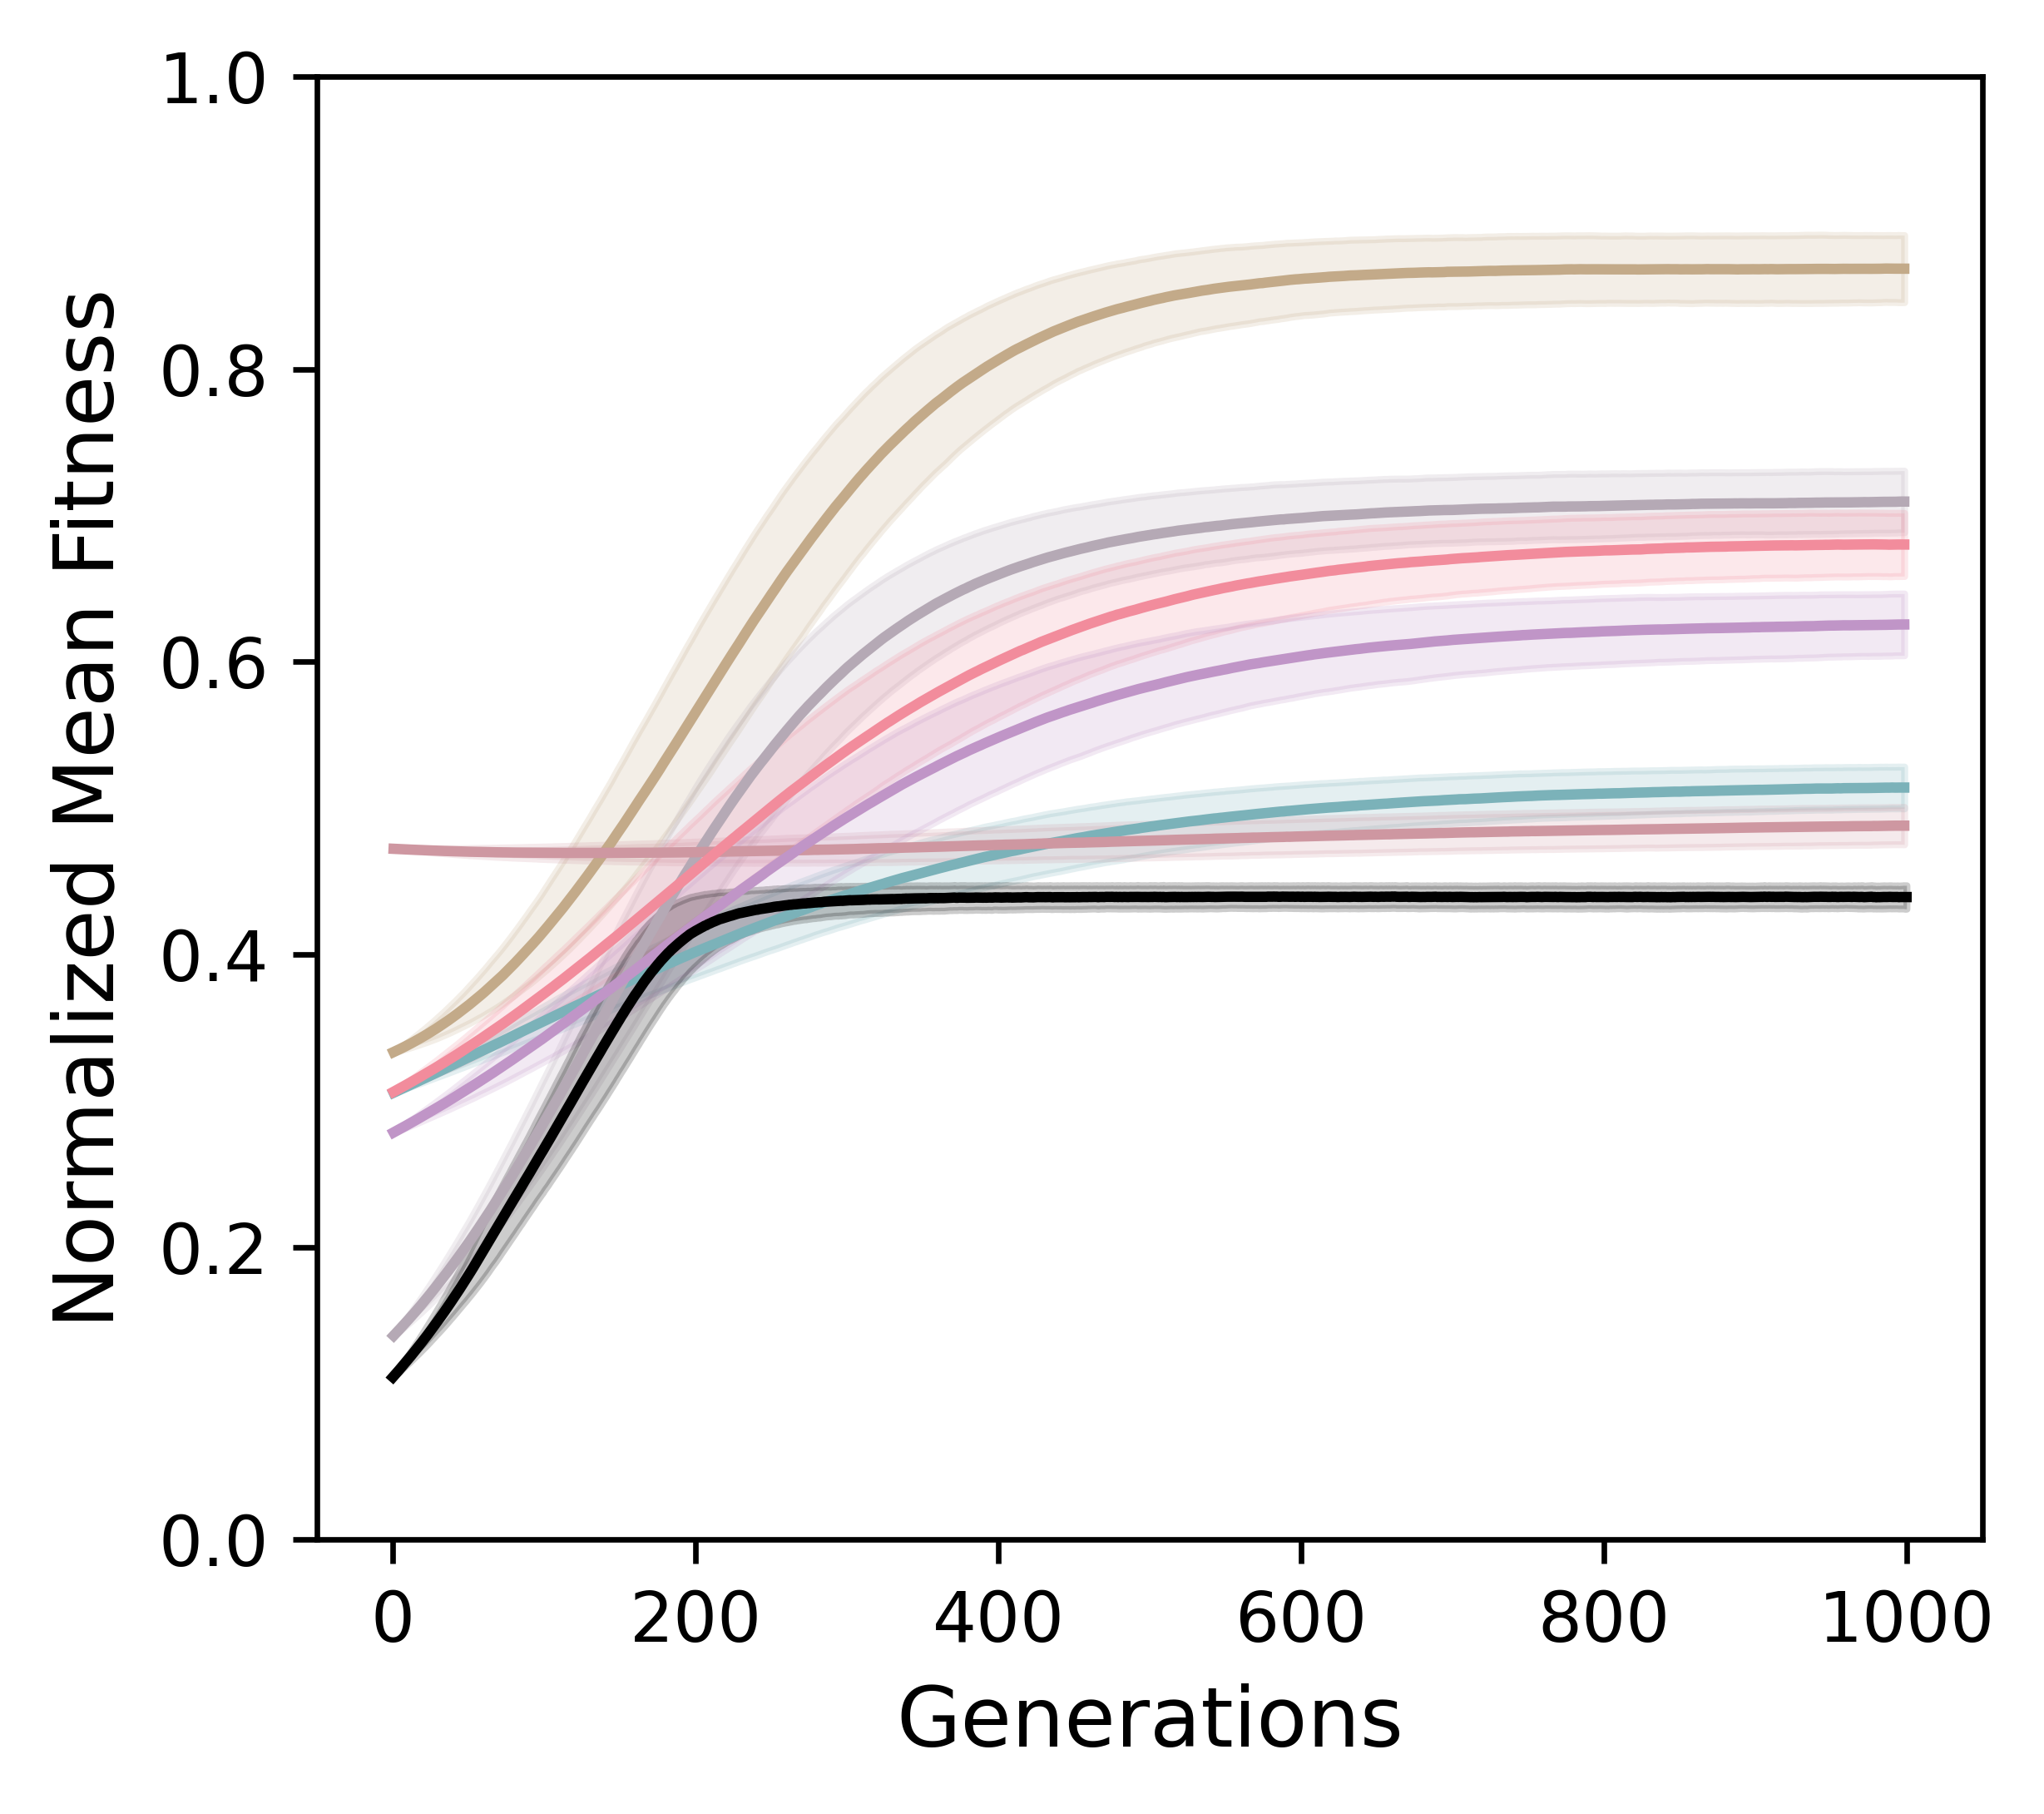

In [120]:
# all_fit_two: (n_pairs+1, n_reps, T); last row = MDP copied from all_fit[-1]
P, R, T = all_fit_two.shape
n_pairs = P - 1
T_even  = (T // 2) * 2

# --- 2-gen average ONLY for the pairs (exclude the last MDP row) ---
two_cycle = all_fit_two[:n_pairs, :, :T_even].reshape(n_pairs, R, T_even//2, 2).mean(axis=3)
mean_pairs = two_cycle.mean(axis=1)               # (n_pairs, T_even/2)
std_pairs  = two_cycle.std(axis=1)                # (n_pairs, T_even/2)

# --- MDP stays per-generation (no 2-gen averaging) ---
mdp_mean = mean_fit_norm[-1]
mdp_std  = std_fit_norm[-1]

# --- normalize everything with your existing global_min/global_max ---
den = max(global_max - global_min, 1e-12)
mean_pairs_norm = (mean_pairs - global_min) / den
std_pairs_norm  =  std_pairs / den

# --- time axes: pairs use 2-gen midpoints; MDP uses original t ---
t2 = t[:T_even].reshape(-1, 2).mean(axis=1)       # (T_even/2,)

# ===== plot: pairs (2-gen averaged) vs MDP (original) =====
#tab = plt.cm.tab20.colors

plt.figure(figsize=(4.2, 4/4.5*4.2), dpi=600)

# pairs
for i in range(n_pairs):
    m, s = mean_pairs_norm[i], std_pairs_norm[i]
    col  = pair_colors[i]
    plt.plot(t2, m, color=col, label=pair_labels[i])
    # comment next line if you want means only:
    plt.fill_between(t2, m - s, m + s, color=col, alpha=0.2)

# MDP (no averaging)
plt.plot(t, mdp_mean, color="black", label="MDP")
# comment next line if you want means only:
plt.fill_between(t, mdp_mean - mdp_std, mdp_mean + mdp_std,
                 color="black", alpha=0.2)

plt.xlabel("Generations", fontsize=12)
plt.ylabel("Normalized Mean Fitness", fontsize=12)
plt.ylim(0, 1)
#plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0, frameon=False)
plt.tight_layout()
plt.show()


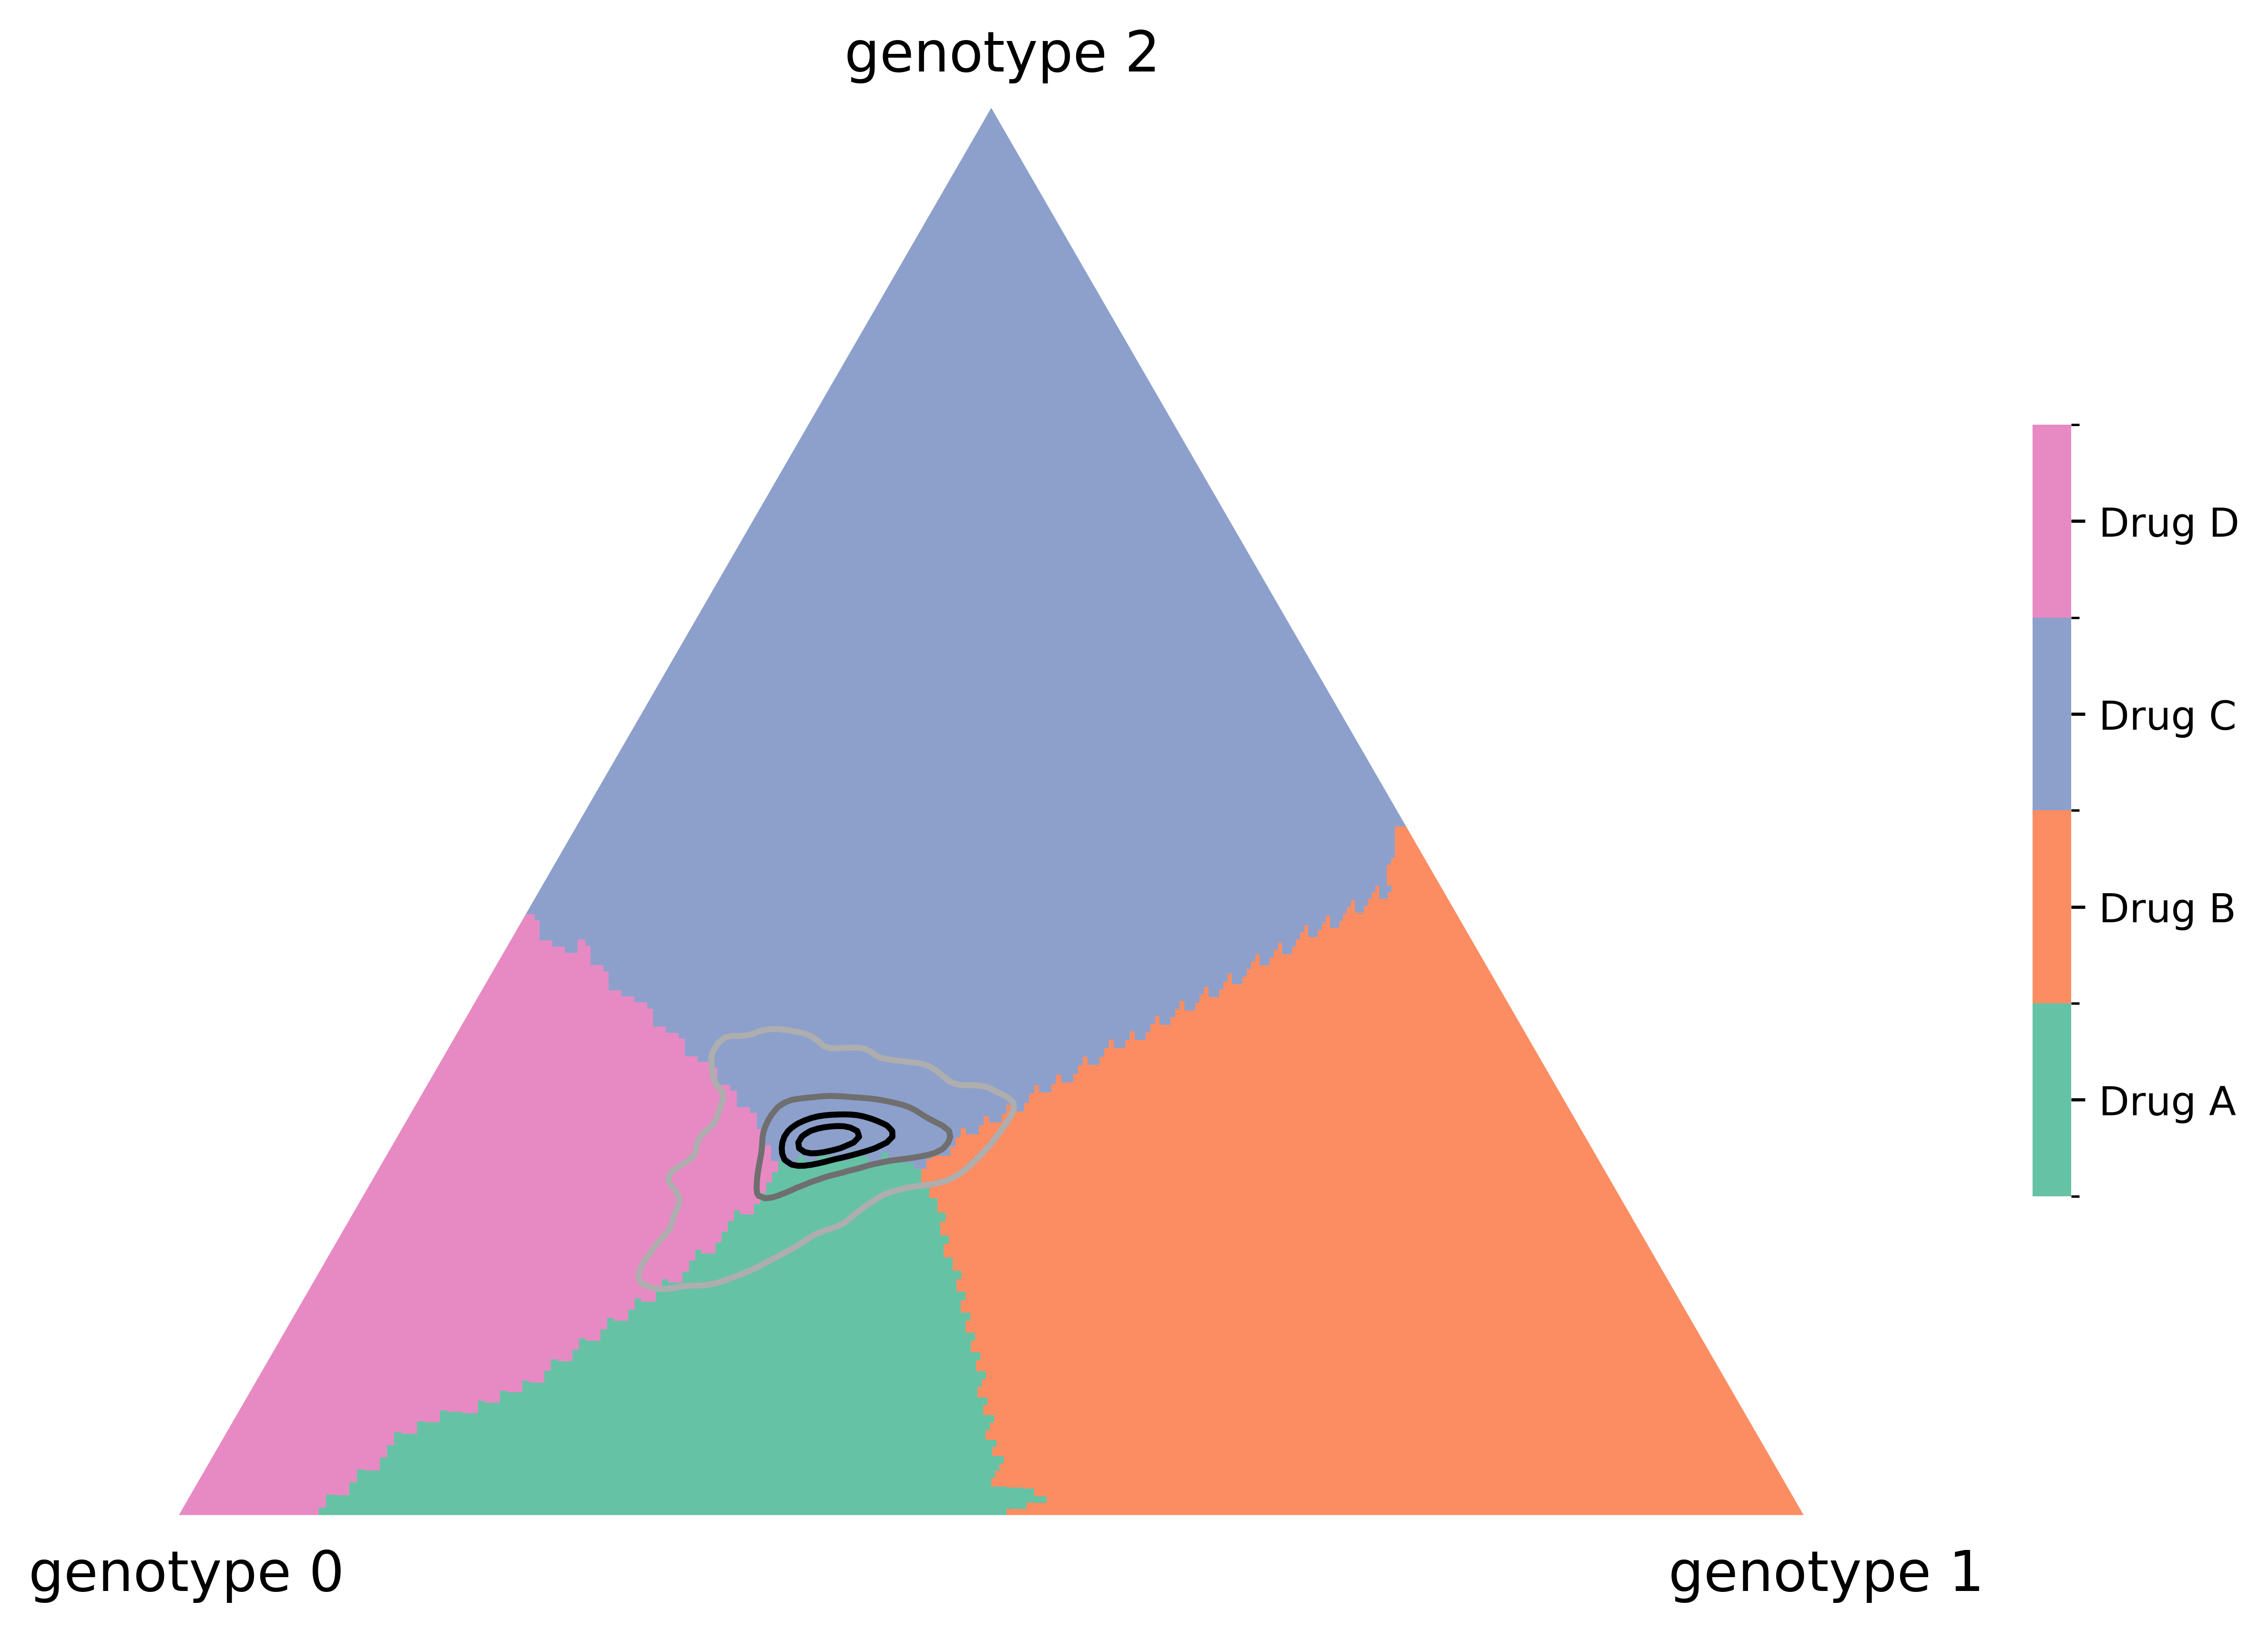

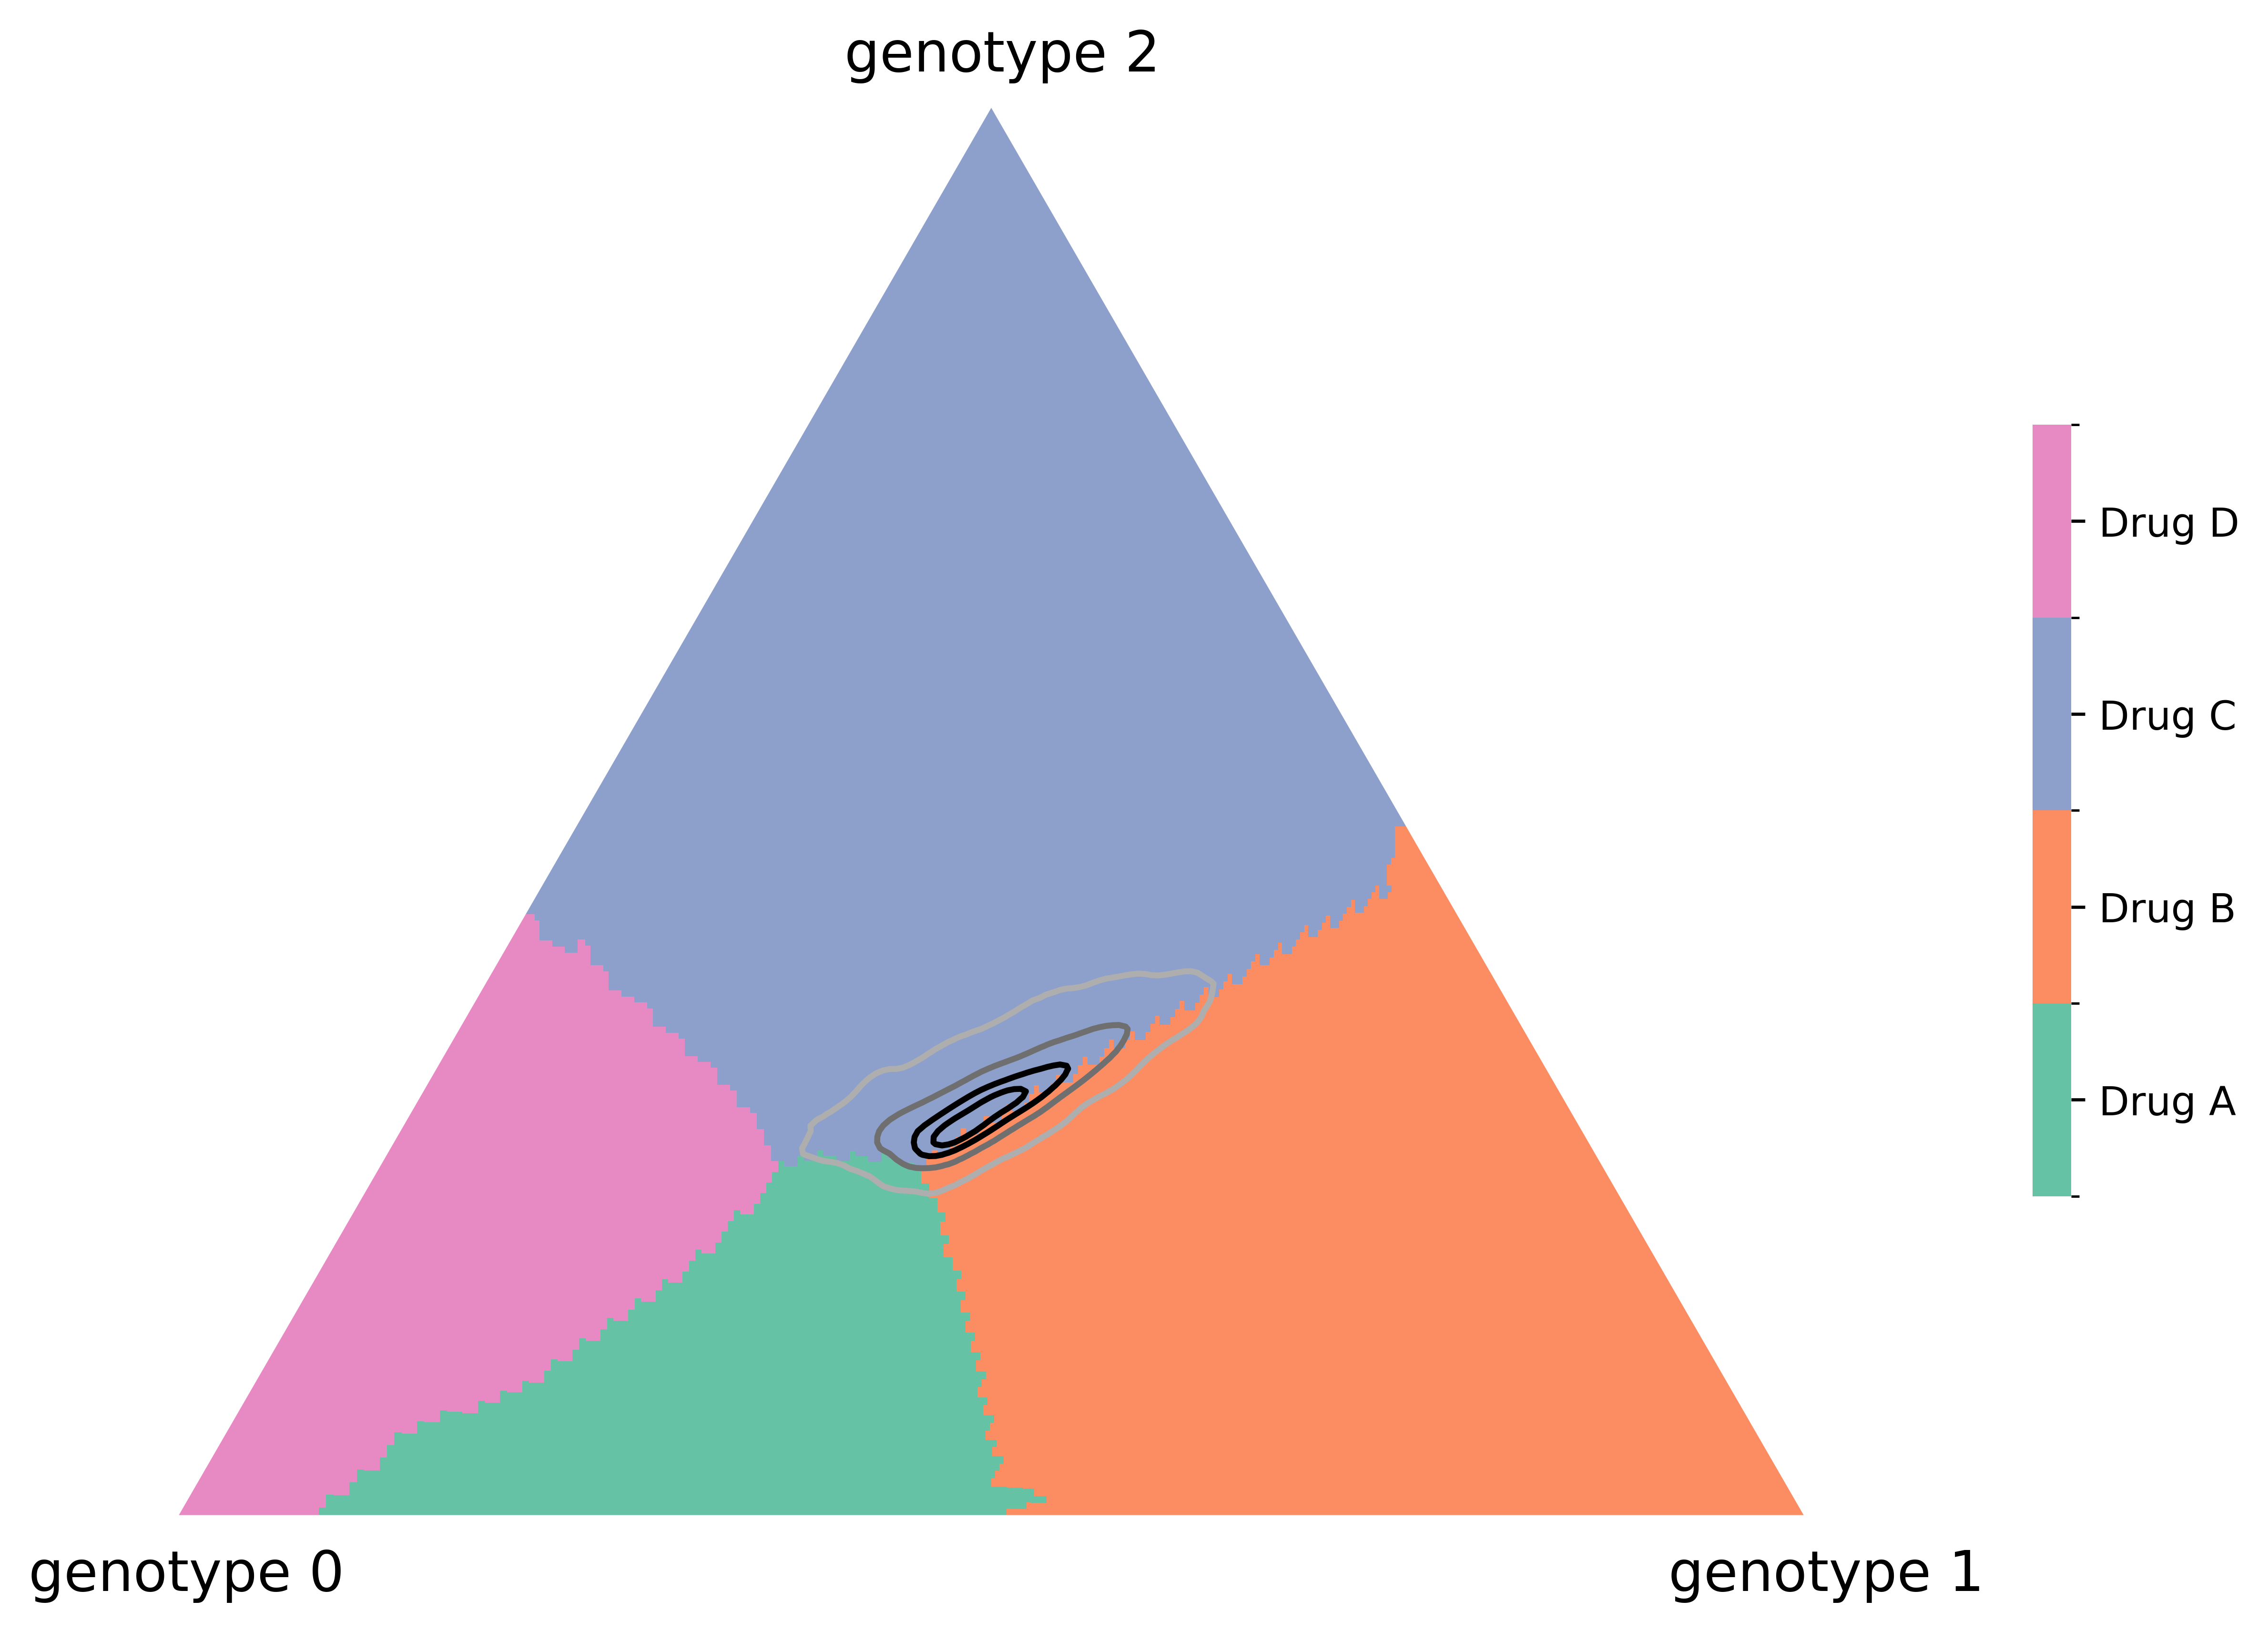

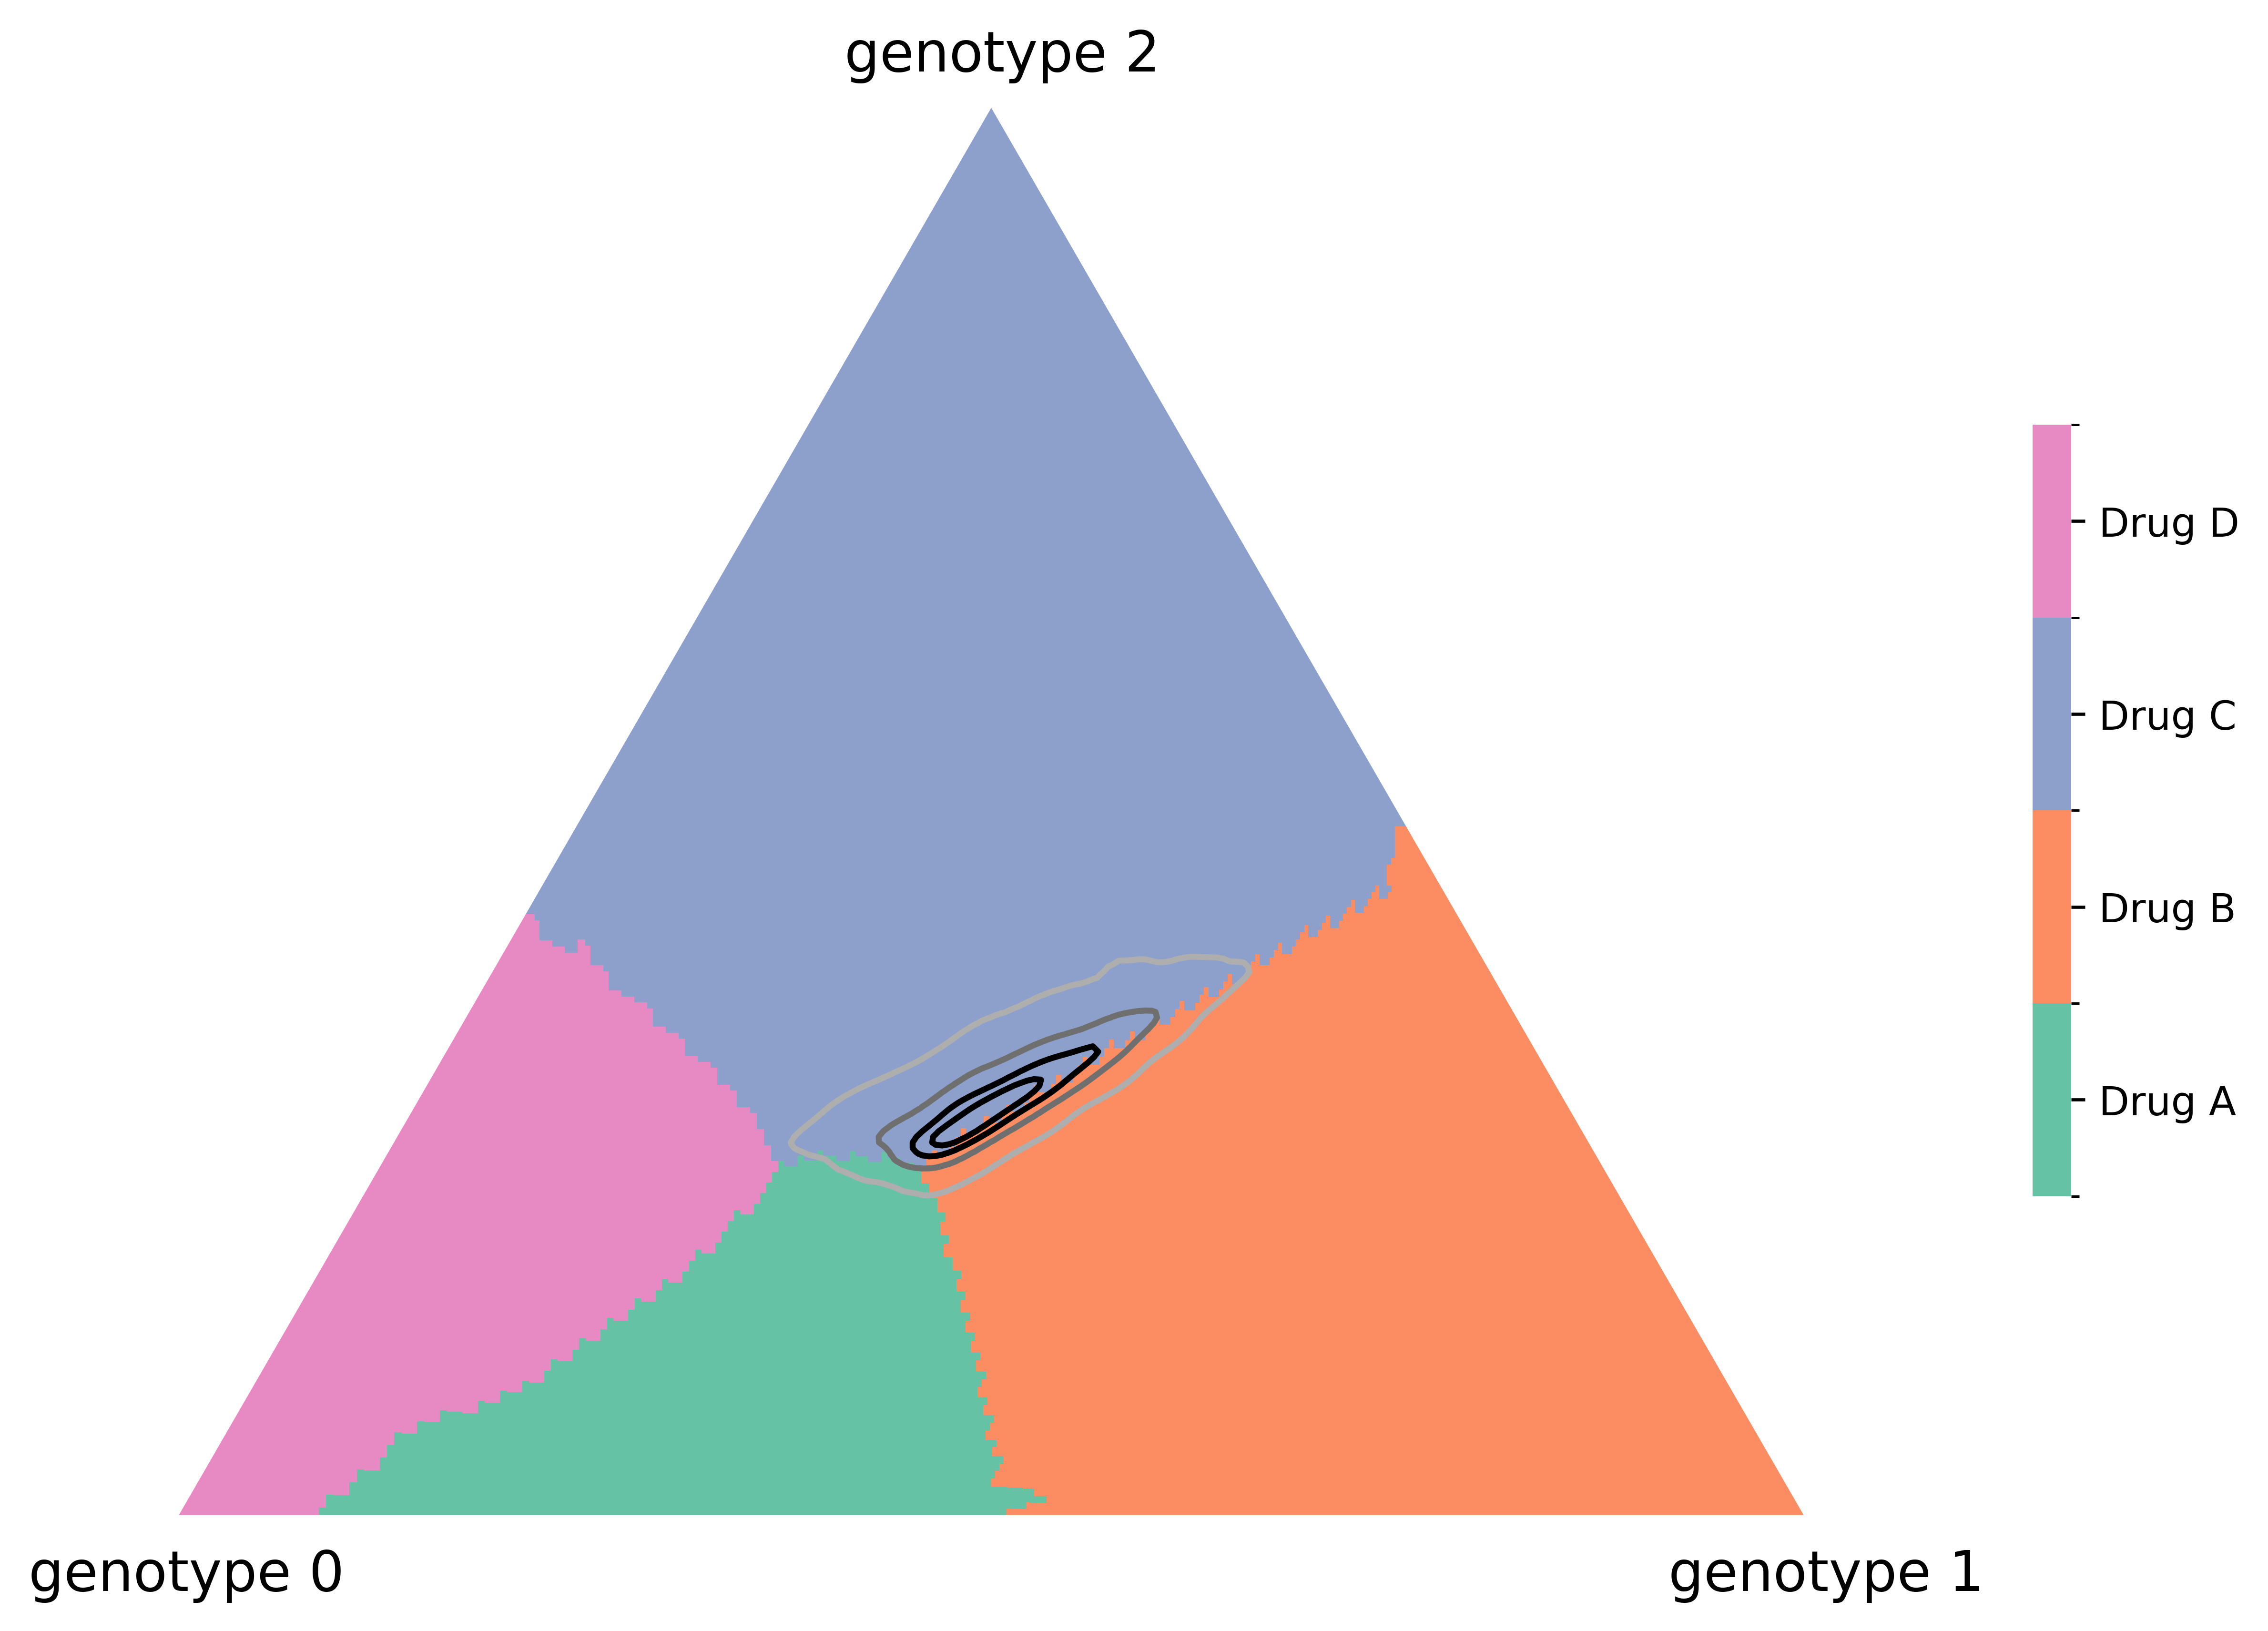

In [48]:
from scipy.stats import gaussian_kde
from matplotlib.path import Path
import matplotlib.cm as cm

def draw_policy_background(ax):
    # policy background (square markers clipped to triangle)
    pix_to_pt = 72/300
    fig_w_px  = fig.get_figwidth() * fig.dpi
    cell_px   = fig_w_px / L
    cell_pt   = cell_px * pix_to_pt
    s_val     = cell_pt**2

    sc = ax.scatter(
        Xf, Yf,
        c=policy_grid.ravel(),
        cmap=cmap, norm=norm,
        marker='s', s=s_val,
        linewidths=0, edgecolors='none'
    )

    # clip to simplex
    triangle_coords = np.array([[0,0],[1,0],[0.5,np.sqrt(3)/2]])
    clip_path = Polygon(triangle_coords, closed=True, transform=ax.transData)
    sc.set_clip_path(clip_path)

    # simplex boundary & labels
    triangle = np.array([[0,0],[1,0],[0.5,np.sqrt(3)/2],[0,0]])
    ax.plot(triangle[:,0], triangle[:,1], '-', lw=1, color='white')
    ax.set_aspect('equal')
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, np.sqrt(3)/2 + 0.02)
    ax.set_xticks([]); ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.text(-0.09, -0.045, 'genotype 0', fontsize=14)
    ax.text(0.915, -0.045, 'genotype 1', fontsize=14)
    ax.text(0.41,  np.sqrt(3)/2 + 0.02, 'genotype 2', fontsize=14)

    # colorbar
    cbar = plt.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        ax=ax, ticks=[0,1,2,3], fraction=0.02, pad=0.1
    )
    cbar.ax.set_yticklabels([f'Drug {n}' for n in ['A','B','C','D']])
    cbar.outline.set_visible(False)

def plot_kde_contour_over_policy(samples_freq, title, levels=(0.02, 0.20, 0.50, 0.80)):
    """
    samples_freq: array shape (n_reps, 3) of genotype frequencies [x0,x1,x2]
    levels: contour levels in *relative KDE density* quantiles (0..1)
    """
    # map genotype freq -> 2D simplex coordinates
    x1 = samples_freq[:,1]
    x2 = samples_freq[:,2]
    Xs = x1 + 0.5 * x2
    Ys = (np.sqrt(3)/2) * x2

    # KDE in XY
    pts = np.vstack([Xs, Ys])
    kde = gaussian_kde(pts)

    # evaluation grid inside the triangle
    nx = ny = 250
    Xg = np.linspace(0.0, 1.0, nx)
    Yg = np.linspace(0.0, np.sqrt(3)/2, ny)
    XX, YY = np.meshgrid(Xg, Yg)

    # mask points outside the simplex
    tri_path = Path(np.array([[0,0],[1,0],[0.5,np.sqrt(3)/2]]))
    mask = ~tri_path.contains_points(np.c_[XX.ravel(), YY.ravel()])  # True = outside

    ZZ = kde(np.vstack([XX.ravel(), YY.ravel()]))
    ZZ[mask] = np.nan
    ZZ = ZZ.reshape(YY.shape)

    # Normalize ZZ to [0,1]
    ZZn = ZZ / np.nanmax(ZZ)

    # plot
    fig, ax = plt.subplots(figsize=(8,7), dpi=600)
    draw_policy_background(ax)

    # contours without labels
   # ax.contour(XX, YY, ZZn, levels=levels, linewidths=1.8, colors='k')
        # use colormap for contour colors
    cmap = cm.Greys
    colors = [cmap(0.4 + 1.2*l) for l in levels]

    #import matplotlib.colors as mcolors
    #alphas = np.linspace(0.2, 1.0, len(levels))  # faint → strong
    #colors = [mcolors.to_rgba("black", alpha=a) for a in alphas]

    ax.contour(XX, YY, ZZn, levels=levels, linewidths=1.5, colors=colors)

    #ax.set_title(title, fontsize=10)
    plt.tight_layout()
    plt.show()



# ==== Build arrays from your collected samples and plot ====
for g in gens_of_interest:
    samples = np.stack(samples_mdp[g], axis=0)   # shape (n_reps, 3)
    plot_kde_contour_over_policy(samples, title=f"generation {g}")
